In [ ]:
!pip install -q numpy pillow opencv-python-headless scikit-image matplotlib pandas tqdm

Taking Input

In [ ]:
from google.colab import files
import os

# Create folders inside /content
before_dir = "/content/before"       # originals (e.g., test_001.png)
blur_dir   = "/content/blurred"      # blurred (e.g., blurred_test_001.png)
after_dir  = "/content/enhanced"     # enhanced (e.g., enhanced_test_001.png)
compare_dir = "/content/comparison"  # comparison plots (e.g., test_001_comparison.png)

for p in [before_dir, blur_dir, after_dir,compare_dir]:
    os.makedirs(p, exist_ok=True)

print("Upload your test images (original clean images):")
uploaded = files.upload()

# Save uploaded files into before_dir
for fn, file_obj in uploaded.items():
    with open(os.path.join(before_dir, fn), "wb") as f:
        f.write(file_obj)
print("Uploaded to", before_dir)


Upload your test images (original clean images):


Saving test_001.png to test_001.png
Saving test_002.png to test_002.png
Saving test_003.png to test_003.png
Saving test_004.png to test_004.png
Saving test_005.png to test_005.png
Saving test_006.png to test_006.png
Saving test_007.png to test_007.png
Saving test_008.png to test_008.png
Saving test_009.png to test_009.png
Saving test_010.png to test_010.png
Saving test_011.png to test_011.png
Saving test_012.png to test_012.png
Uploaded to /content/before


Blurring Image


In [ ]:
import cv2
from tqdm import tqdm

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

for fn in tqdm(os.listdir(before_dir)):
    if not fn.lower().endswith(('.png','.jpg','.jpeg')):
        continue
    path = os.path.join(before_dir, fn)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Create blurred version
    blurred = clahe.apply(img)
    gaussian = cv2.GaussianBlur(blurred, (0, 0), 10)
    blurred = cv2.addWeighted(blurred, 0.3, gaussian, 0.7, 0)
    cv2.imwrite(os.path.join(blur_dir, "blurred_" + fn), blurred)


100%|██████████| 12/12 [00:00<00:00, 32.90it/s]


Model Resultant Images

In [ ]:
print("Upload your resultant test images from SRCNN:")
uploaded = files.upload()

# Save uploaded files into after_dir
for fn, file_obj in uploaded.items():
    with open(os.path.join(after_dir, fn), "wb") as f:
        f.write(file_obj)
print("Uploaded to", after_dir)

Upload your resultant test images from SRCNN:


Saving enhanced_test_012.png to enhanced_test_012.png
Saving enhanced_test_011.png to enhanced_test_011.png
Saving enhanced_test_010.png to enhanced_test_010.png
Saving enhanced_test_009.png to enhanced_test_009.png
Saving enhanced_test_008.png to enhanced_test_008.png
Saving enhanced_test_007.png to enhanced_test_007.png
Saving enhanced_test_006.png to enhanced_test_006.png
Saving enhanced_test_005.png to enhanced_test_005.png
Saving enhanced_test_004.png to enhanced_test_004.png
Saving enhanced_test_003.png to enhanced_test_003.png
Saving enhanced_test_002.png to enhanced_test_002.png
Saving enhanced_test_001.png to enhanced_test_001.png
Uploaded to /content/enhanced


In [ ]:
import cv2
from tqdm import tqdm

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

for fn in tqdm(os.listdir(after_dir)):
    if not fn.lower().endswith(('.png','.jpg','.jpeg')):
        continue
    path = os.path.join(after_dir, fn)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Denoise softly (reduce sigma to avoid cartoon effect)
    denoised = cv2.bilateralFilter(img, d=7, sigmaColor=50, sigmaSpace=50)

    # Gentle sharpening (reduce weights)
    sharpened = cv2.addWeighted(denoised, 1.2, cv2.GaussianBlur(denoised, (0,0), 2), -0.2, 0)

    # Softer CLAHE (reduce clipLimit, larger tileGridSize for smoother contrast)
    clahe_balanced = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(16,16))
    enhanced = clahe_balanced.apply(sharpened)

    cv2.imwrite(os.path.join(after_dir, fn), enhanced)

100%|██████████| 12/12 [00:00<00:00, 80.04it/s]


Metrics Calculation

In [ ]:
import os
import cv2
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from google.colab import files
import zipfile
import matplotlib.pyplot as plt

# Paths
output_csv = "/content/validation_results.csv"
output_zip = "/content/validation_results.zip"

results = []

for fn in sorted(os.listdir(before_dir)):
    if not fn.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    # --- Original ---
    orig_path = os.path.join(before_dir, fn)
    original = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)

    # --- Blurred version ---
    blur_fn = "blurred_" + fn
    blur_path = os.path.join(blur_dir, blur_fn)
    if not os.path.exists(blur_path):
        print(f"Skipping {fn}, no blurred version found")
        continue
    blurred = cv2.imread(blur_path, cv2.IMREAD_GRAYSCALE)

    # --- Enhanced version ---
    after_fn = "enhanced_" + fn   # mapping: test_001.png → enhanced_test_001.png
    after_path = os.path.join(after_dir, after_fn)
    if not os.path.exists(after_path):
        print(f"Skipping {fn}, no enhanced version found")
        continue
    enhanced = cv2.imread(after_path, cv2.IMREAD_GRAYSCALE)

    # --- Ensure same size ---
    for name, img in [("blurred", blurred), ("enhanced", enhanced)]:
        if img.shape != original.shape:
            resized = cv2.resize(img, (original.shape[1], original.shape[0]))
            if name == "blurred":
                blurred = resized
            else:
                enhanced = resized

    # --- Metrics ---
    psnr_before = peak_signal_noise_ratio(original, blurred, data_range=255)
    psnr_after  = peak_signal_noise_ratio(original, enhanced, data_range=255)

    ssim_before = structural_similarity(original, blurred, data_range=255)
    ssim_after = structural_similarity(original, enhanced, data_range=255)

    results.append({
        "image": fn,
        "PSNR_before": psnr_before,
        "PSNR_after": psnr_after,
        "SSIM_before": ssim_before,
        "SSIM_after": ssim_after,
        "delta_PSNR": psnr_after - psnr_before,
        "delta_SSIM": ssim_after - ssim_before
    })

     # Save comparison plot
    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    ax[0].imshow(original, cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
    ax[1].imshow(blurred, cmap="gray");  ax[1].set_title("Before (Blurred)"); ax[1].axis("off")
    ax[2].imshow(enhanced); ax[2].set_title("After (Enhanced)"); ax[2].axis("off")
    plt.savefig(os.path.join(compare_dir, fn.split('.')[0] + "_comparison.png"))
    plt.close()

# --- Save to CSV ---
df = pd.DataFrame(results)
df.to_csv(output_csv, index=False)

print(df)

           image  PSNR_before  PSNR_after  SSIM_before  SSIM_after  \
0   test_001.png    22.040533   14.090469     0.916940    0.709240   
1   test_002.png    25.513411   12.651304     0.931673    0.708293   
2   test_003.png    19.808246   15.536791     0.857198    0.678791   
3   test_004.png    15.513557   13.538328     0.684970    0.492938   
4   test_005.png    22.159520   15.285362     0.792984    0.593386   
5   test_006.png    18.333667   18.571277     0.791609    0.717760   
6   test_007.png    20.378316   16.524037     0.857737    0.712154   
7   test_008.png    21.273086   16.529908     0.831274    0.631290   
8   test_009.png    20.540580   12.020199     0.859911    0.619006   
9   test_010.png    18.475739   19.596033     0.622510    0.423481   
10  test_011.png    16.142670   12.819223     0.687617    0.471862   
11  test_012.png    18.877719   16.281418     0.585237    0.392401   

    delta_PSNR  delta_SSIM  
0    -7.950064   -0.207700  
1   -12.862107   -0.223380  
2 

Comparison of Images

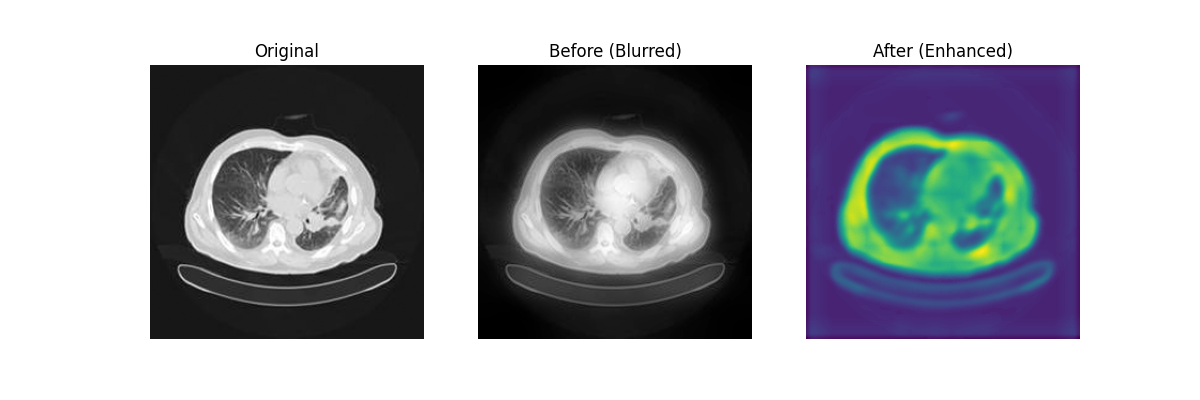

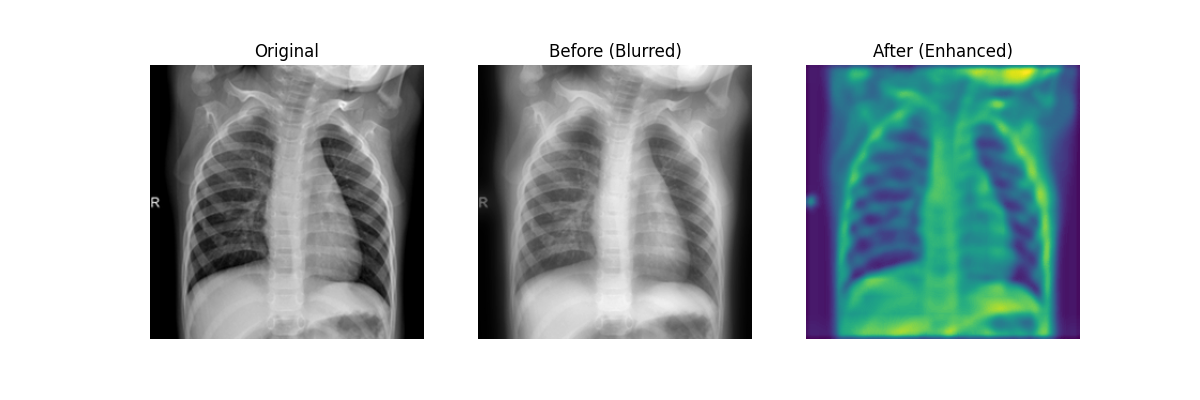

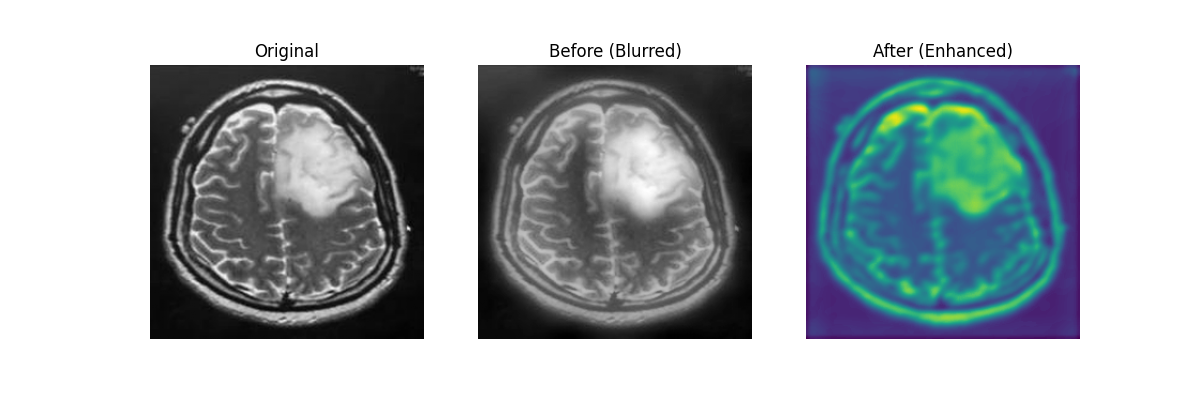

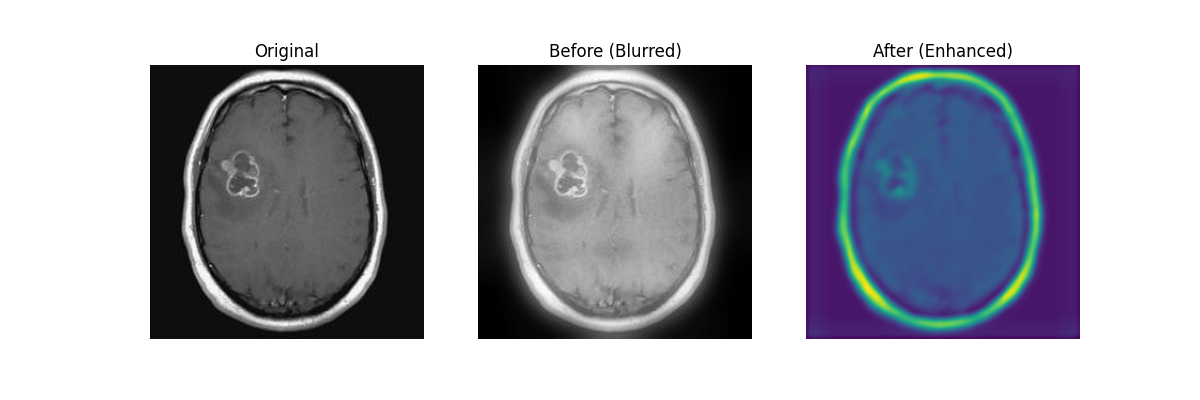

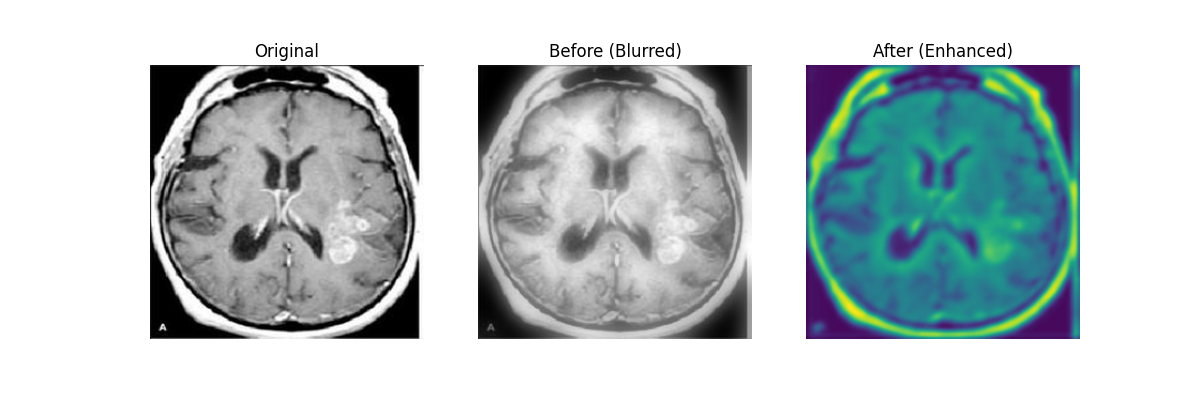

In [ ]:
from IPython.display import Image, display
import glob

samples = glob.glob(os.path.join(compare_dir, "*_comparison.png"))[:5]
for s in samples:
    display(Image(filename=s, width=900))


Download Result

In [ ]:
# --- Zip results (CSV + enhanced images if you want) ---
with zipfile.ZipFile(output_zip, 'w') as zipf:
    zipf.write(output_csv, os.path.basename(output_csv))

# --- Download ---
files.download(output_zip)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download comparison images

In [ ]:
import shutil
from google.colab import files

# path of your folder in Colab
folder_path = compare_dir

# zip output path
output_zip = "/content/comparison.zip"

# create a zip file
shutil.make_archive("/content/comparison", 'zip', folder_path)

# download the zip
files.download(output_zip)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>